In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np


 **Question-1**

In [ ]:

# ✅ Automatically use GPU if available (T4 on Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CIFAR-10 class indices: cat = 3, dog = 5
target_classes = [3, 5]

# Transforms (normalized for GAN: [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # For 3 channels: normalize RGB to [-1, 1]
])

# Download dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter for cat and dog
def filter_cat_dog(dataset):
    indices = [i for i, label in enumerate(dataset.targets) if label in target_classes]
    return Subset(dataset, indices)

trainset_cd = filter_cat_dog(trainset)
testset_cd = filter_cat_dog(testset)

# DataLoaders
trainloader_cd = DataLoader(trainset_cd, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
testloader_cd = DataLoader(testset_cd, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)



Using device: cuda


Visual Check Of Data **Q1**

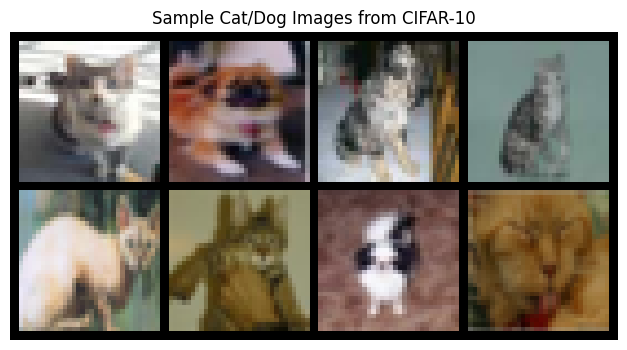

In [ ]:
import torchvision
import matplotlib.pyplot as plt

def show_sample_images(loader):
    data_iter = iter(loader)
    images, _ = next(data_iter)
    images = images[:8]
    grid_img = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    plt.figure(figsize=(8,4))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Sample Cat/Dog Images from CIFAR-10")
    plt.axis('off')
    plt.show()

show_sample_images(trainloader_cd)


In [ ]:
import torch.nn as nn

# Generator (latent_dim → 3x32x32 image)

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256*4*4),
            nn.BatchNorm1d(256*4*4),
            nn.ReLU(True),

            nn.Unflatten(1, (256, 4, 4)),  # [B, 256, 4, 4]

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # [B, 3, 32, 32]
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # (B, 64, 16, 16)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # (B, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.cnn(x)

class SimilarityDiscriminator(nn.Module):
    def __init__(self):
        super(SimilarityDiscriminator, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output similarity score between 0 and 1
        )

    def forward(self, img1, img2):
        feat1 = self.feature_extractor(img1)
        feat2 = self.feature_extractor(img2)
        combined = torch.cat((feat1, feat2), dim=1)
        return self.fc(combined)


Loss function

In [ ]:
# Loss function
criterion = nn.BCELoss()

# Models
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = SimilarityDiscriminator().to(device)

# Optimizers
lr = 0.0002
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
class MiniBatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims=50):
        super().__init__()
        self.T = nn.Parameter(torch.Tensor(in_features, out_features, kernel_dims))
        nn.init.normal_(self.T, mean=0, std=1)

    def forward(self, x):
        M = x @ self.T.view(x.size(1), -1)  # Linear transformation
        M = M.view(x.size(0), -1, self.T.shape[2])  # (batch, out_features, kernel_dims)

        out = torch.zeros(x.size(0), M.size(1), device=x.device)
        for i in range(x.size(0)):
            diff = torch.abs(M[i].unsqueeze(0) - M)
            out[i] = torch.exp(-diff.sum(2)).sum(0) - 1  # exclude self-similarity
        return torch.cat([x, out], dim=1)


GAn Training Loop

100%|██████████| 157/157 [00:05<00:00, 26.69it/s]


Epoch 1/50 | G Loss: 430.01 | D Loss: 55.98


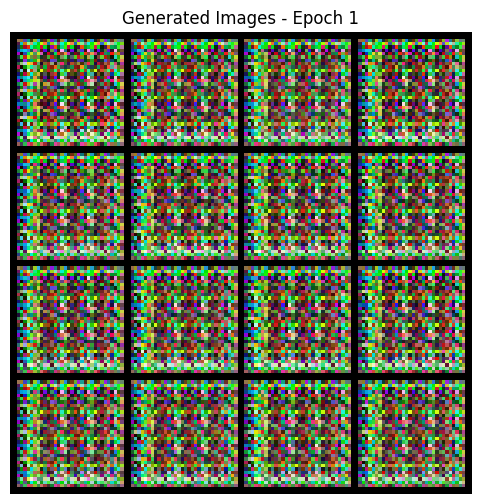

100%|██████████| 157/157 [00:05<00:00, 28.71it/s]

Epoch 2/50 | G Loss: 552.51 | D Loss: 34.31


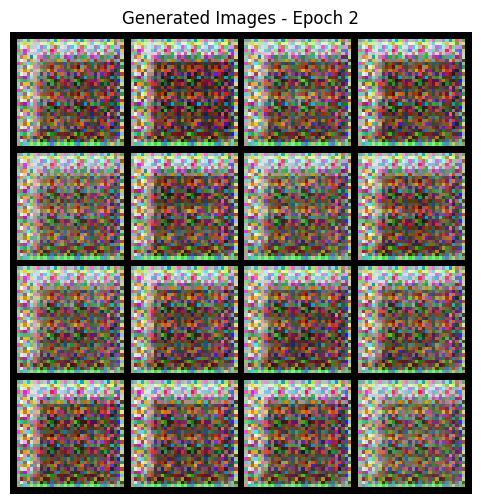

100%|██████████| 157/157 [00:05<00:00, 26.73it/s]

Epoch 3/50 | G Loss: 480.60 | D Loss: 52.12


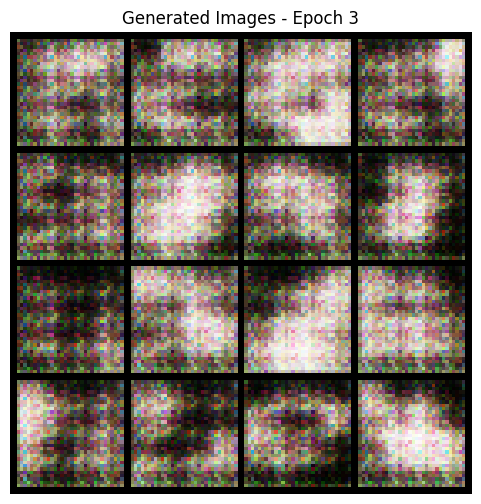

100%|██████████| 157/157 [00:05<00:00, 28.29it/s]

Epoch 4/50 | G Loss: 462.96 | D Loss: 57.39


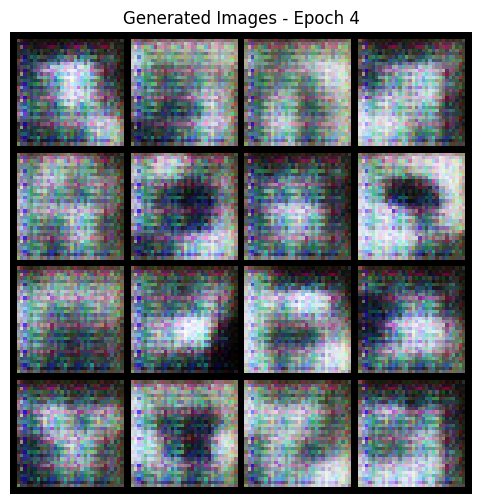

100%|██████████| 157/157 [00:05<00:00, 26.50it/s]

Epoch 5/50 | G Loss: 485.46 | D Loss: 53.14


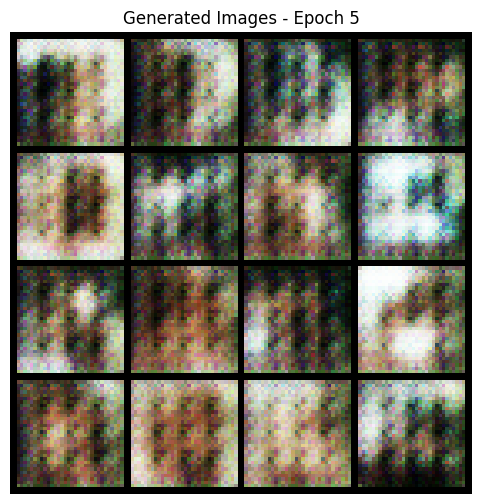

100%|██████████| 157/157 [00:05<00:00, 28.19it/s]

Epoch 6/50 | G Loss: 546.38 | D Loss: 42.79


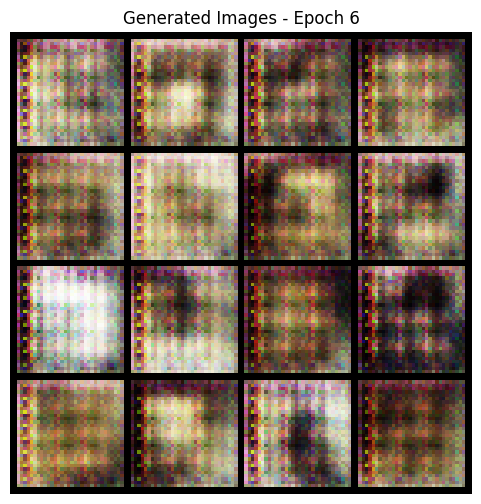

100%|██████████| 157/157 [00:05<00:00, 26.38it/s]


Epoch 7/50 | G Loss: 536.83 | D Loss: 39.65


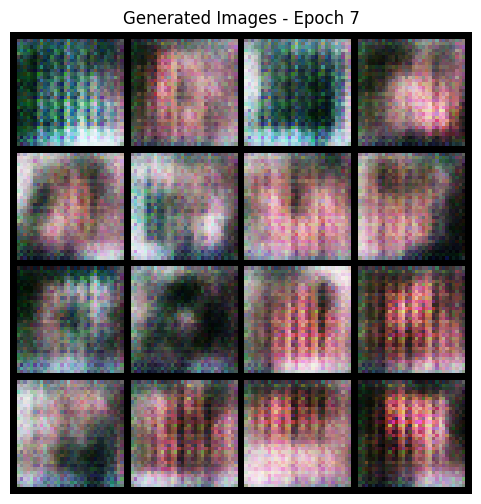

100%|██████████| 157/157 [00:05<00:00, 28.07it/s]

Epoch 8/50 | G Loss: 538.66 | D Loss: 43.23


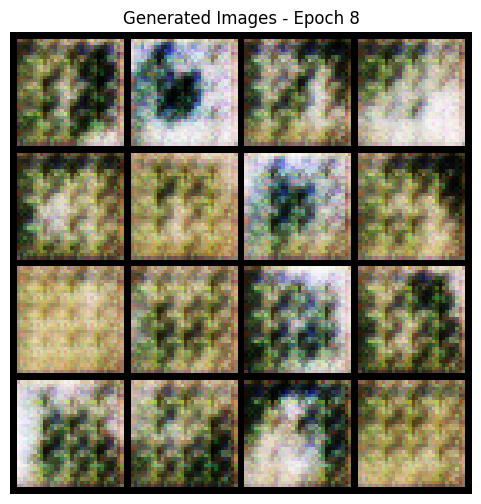

100%|██████████| 157/157 [00:05<00:00, 26.17it/s]


Epoch 9/50 | G Loss: 516.89 | D Loss: 48.10


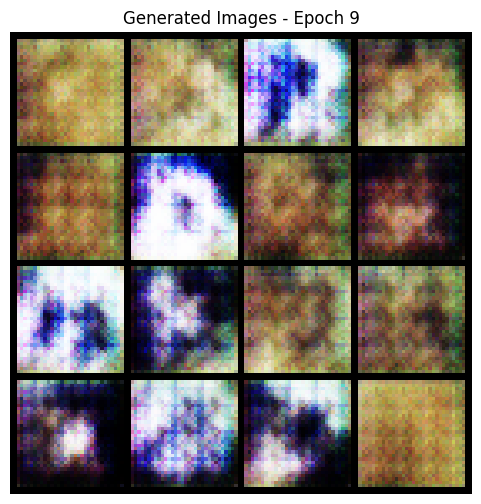

100%|██████████| 157/157 [00:05<00:00, 27.90it/s]


Epoch 10/50 | G Loss: 518.69 | D Loss: 45.19


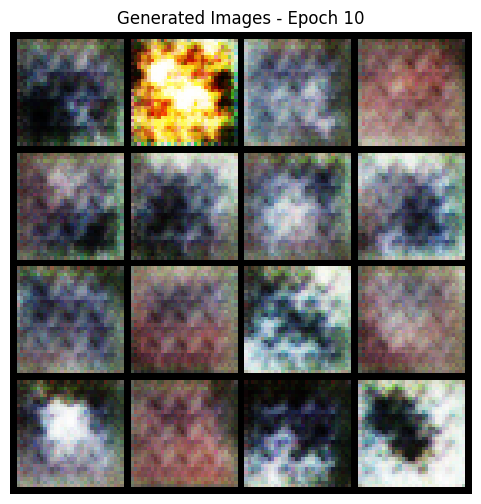

100%|██████████| 157/157 [00:05<00:00, 26.39it/s]


Epoch 11/50 | G Loss: 482.08 | D Loss: 42.23


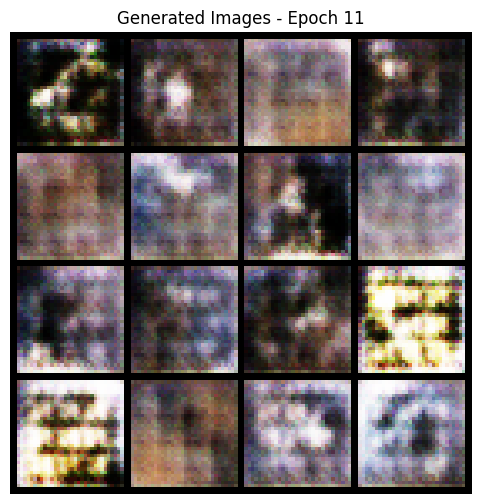

100%|██████████| 157/157 [00:05<00:00, 27.87it/s]

Epoch 12/50 | G Loss: 483.82 | D Loss: 41.24


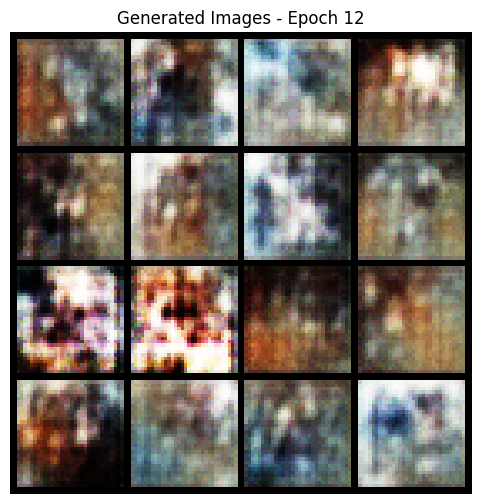

100%|██████████| 157/157 [00:05<00:00, 26.56it/s]


Epoch 13/50 | G Loss: 486.30 | D Loss: 45.69


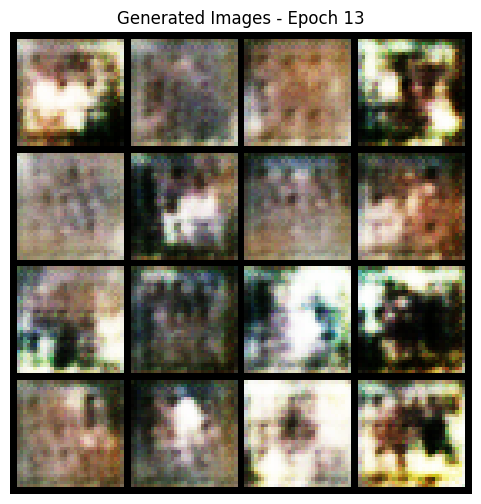

100%|██████████| 157/157 [00:05<00:00, 27.48it/s]


Epoch 14/50 | G Loss: 474.85 | D Loss: 43.91


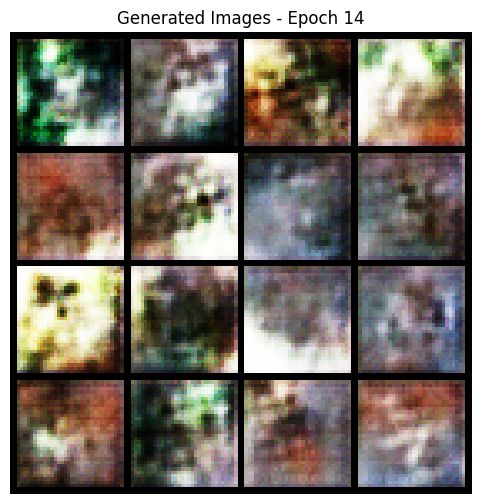

100%|██████████| 157/157 [00:05<00:00, 26.62it/s]


Epoch 15/50 | G Loss: 450.14 | D Loss: 46.44


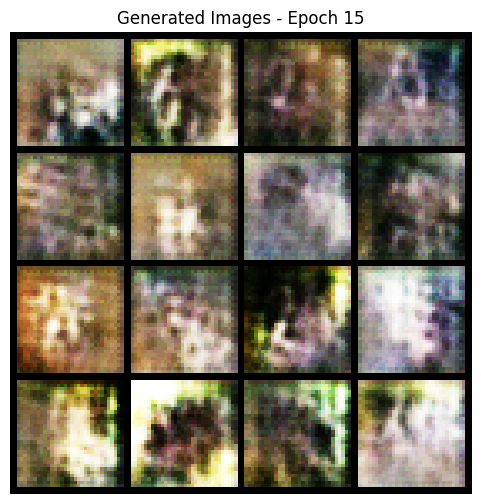

100%|██████████| 157/157 [00:05<00:00, 26.64it/s]


Epoch 16/50 | G Loss: 461.34 | D Loss: 45.85


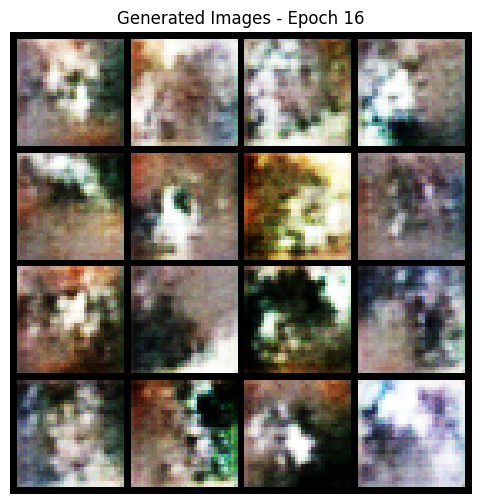

100%|██████████| 157/157 [00:05<00:00, 27.19it/s]


Epoch 17/50 | G Loss: 475.10 | D Loss: 47.73


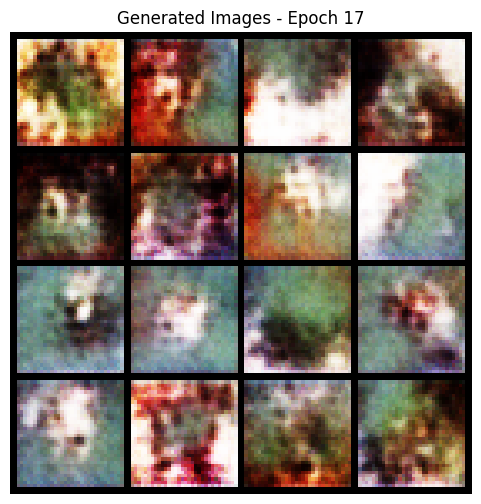

100%|██████████| 157/157 [00:06<00:00, 25.67it/s]


Epoch 18/50 | G Loss: 443.57 | D Loss: 48.78


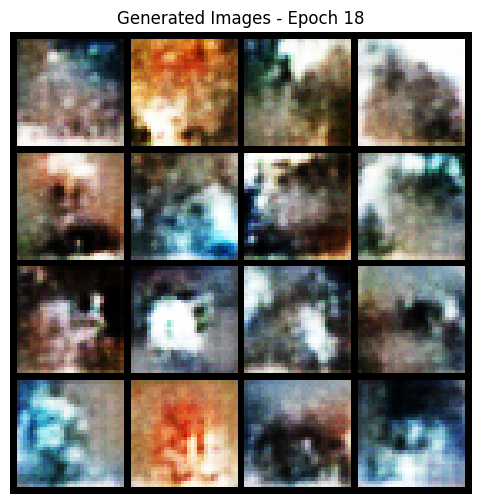

100%|██████████| 157/157 [00:05<00:00, 27.55it/s]


Epoch 19/50 | G Loss: 454.56 | D Loss: 50.51


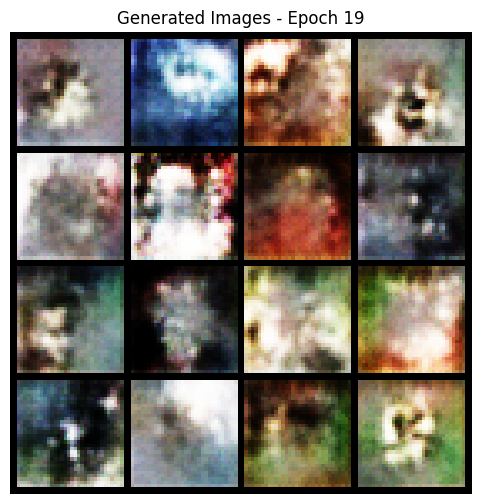

100%|██████████| 157/157 [00:06<00:00, 24.86it/s]


Epoch 20/50 | G Loss: 436.58 | D Loss: 49.49


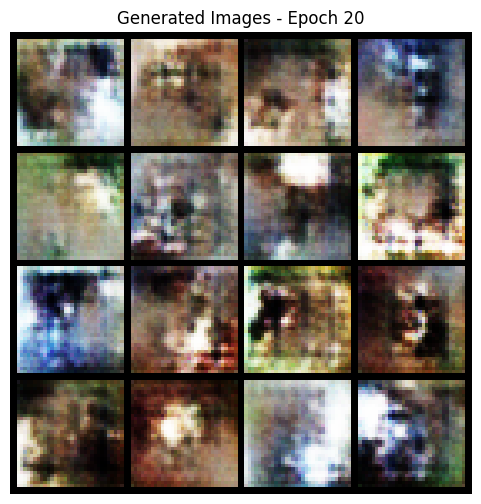

100%|██████████| 157/157 [00:05<00:00, 27.55it/s]


Epoch 21/50 | G Loss: 427.66 | D Loss: 49.27


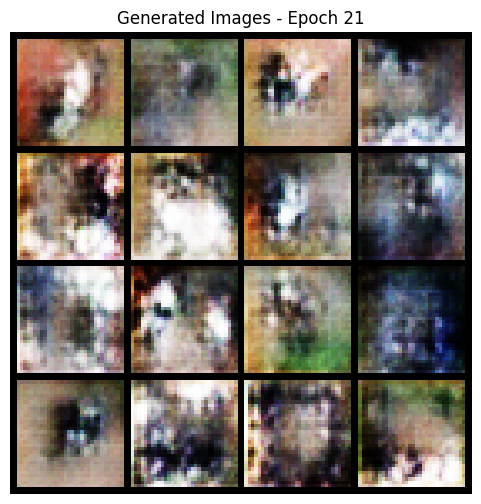

100%|██████████| 157/157 [00:06<00:00, 25.27it/s]


Epoch 22/50 | G Loss: 435.71 | D Loss: 46.31


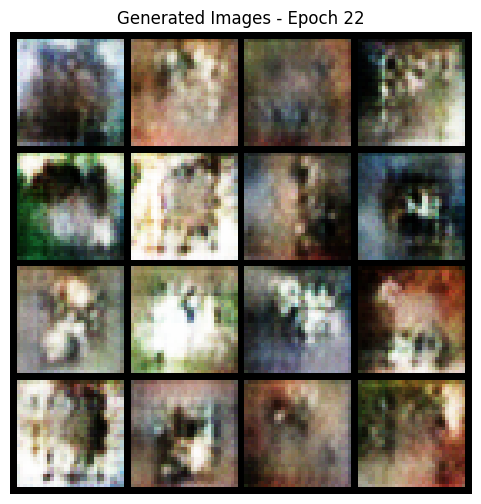

100%|██████████| 157/157 [00:05<00:00, 27.33it/s]


Epoch 23/50 | G Loss: 447.35 | D Loss: 46.75


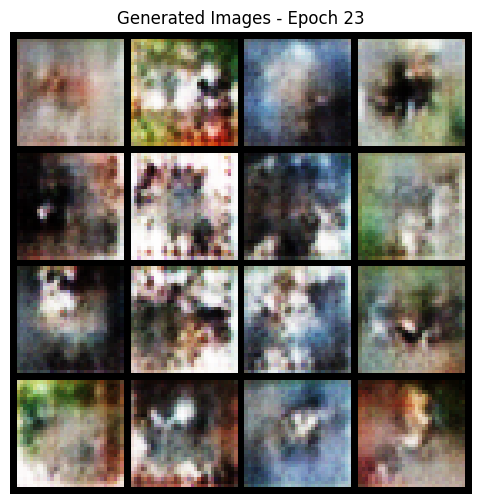

100%|██████████| 157/157 [00:06<00:00, 25.60it/s]


Epoch 24/50 | G Loss: 467.49 | D Loss: 46.82


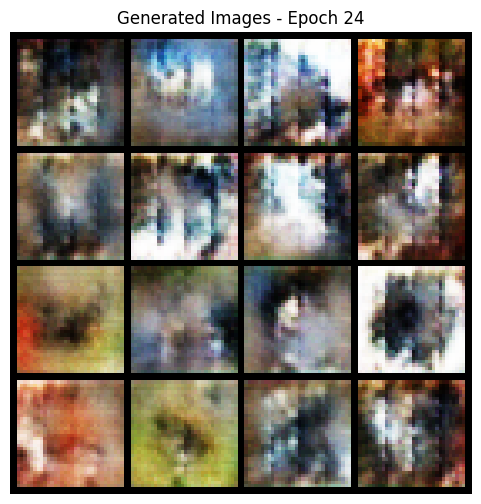

100%|██████████| 157/157 [00:05<00:00, 27.04it/s]


Epoch 25/50 | G Loss: 416.60 | D Loss: 46.92


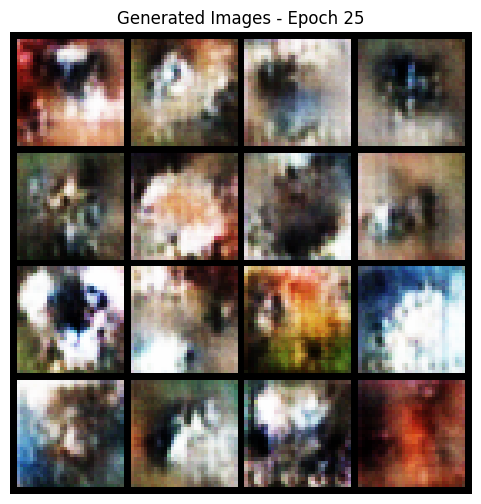

100%|██████████| 157/157 [00:06<00:00, 25.32it/s]


Epoch 26/50 | G Loss: 460.22 | D Loss: 44.44


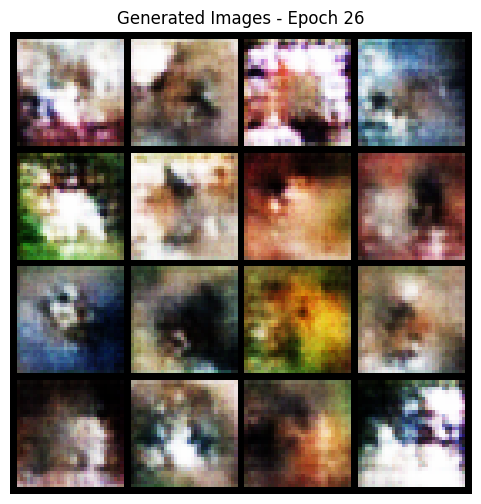

100%|██████████| 157/157 [00:05<00:00, 27.37it/s]


Epoch 27/50 | G Loss: 481.22 | D Loss: 48.19


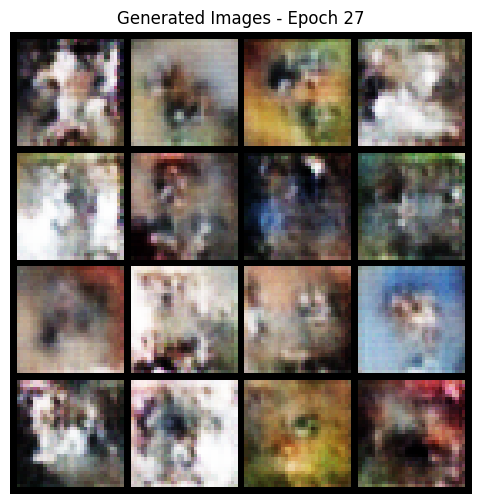

100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


Epoch 28/50 | G Loss: 442.05 | D Loss: 46.11


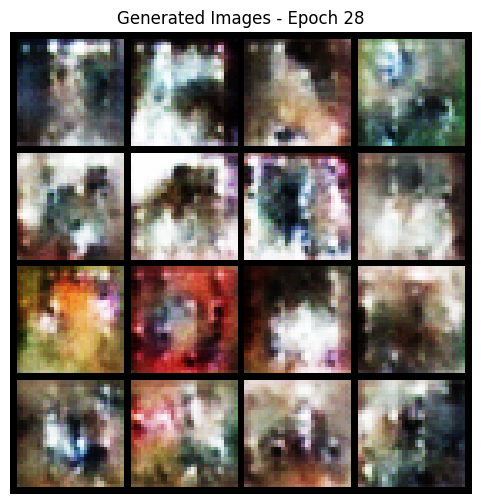

100%|██████████| 157/157 [00:05<00:00, 26.80it/s]


Epoch 29/50 | G Loss: 446.59 | D Loss: 50.07


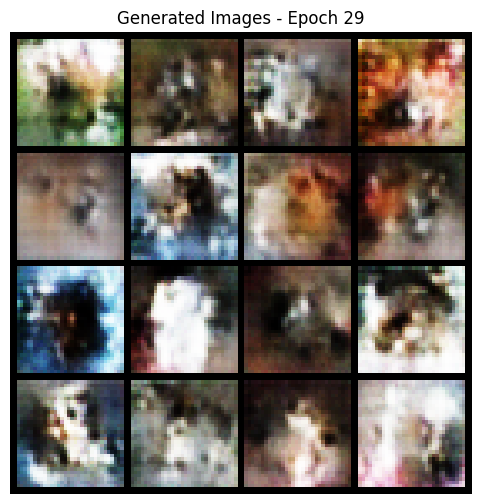

100%|██████████| 157/157 [00:06<00:00, 24.39it/s]


Epoch 30/50 | G Loss: 433.31 | D Loss: 47.40


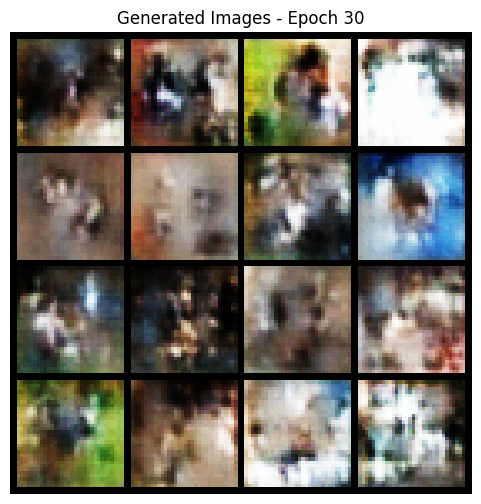

100%|██████████| 157/157 [00:05<00:00, 27.04it/s]


Epoch 31/50 | G Loss: 421.10 | D Loss: 51.34


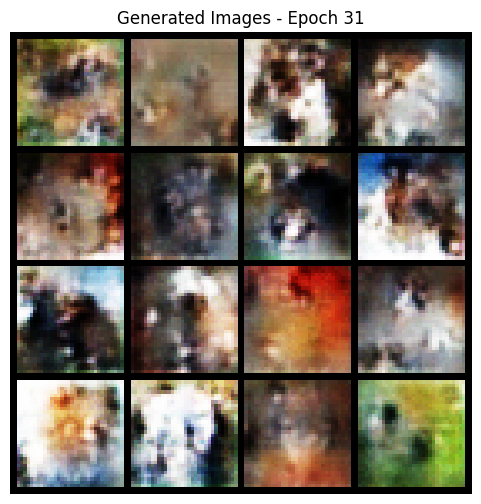

100%|██████████| 157/157 [00:06<00:00, 24.76it/s]


Epoch 32/50 | G Loss: 432.40 | D Loss: 45.49


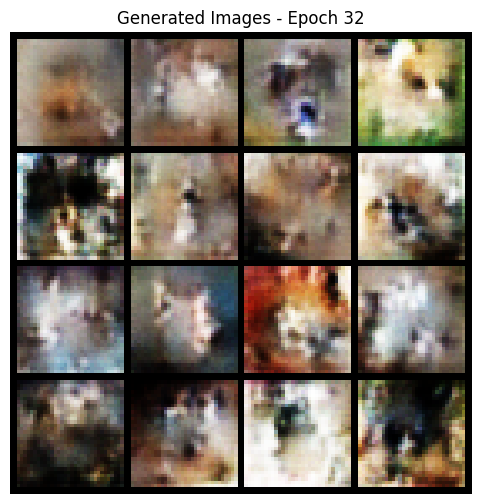

100%|██████████| 157/157 [00:05<00:00, 27.02it/s]


Epoch 33/50 | G Loss: 426.29 | D Loss: 48.35


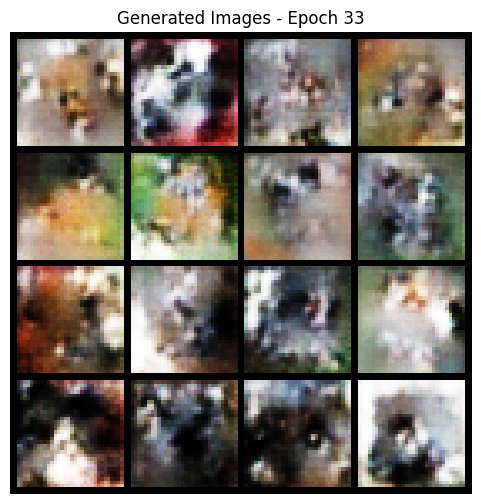

100%|██████████| 157/157 [00:06<00:00, 25.01it/s]


Epoch 34/50 | G Loss: 431.96 | D Loss: 43.88


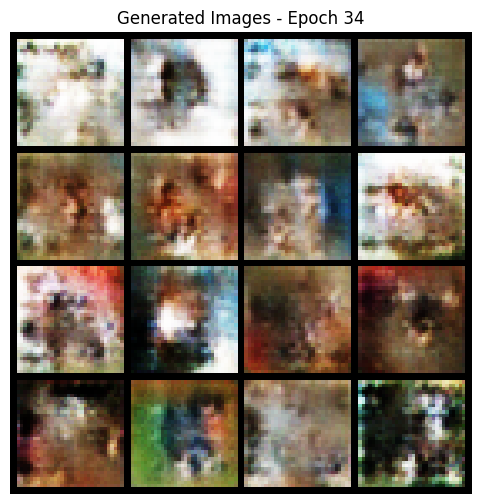

100%|██████████| 157/157 [00:05<00:00, 26.89it/s]


Epoch 35/50 | G Loss: 470.77 | D Loss: 45.27


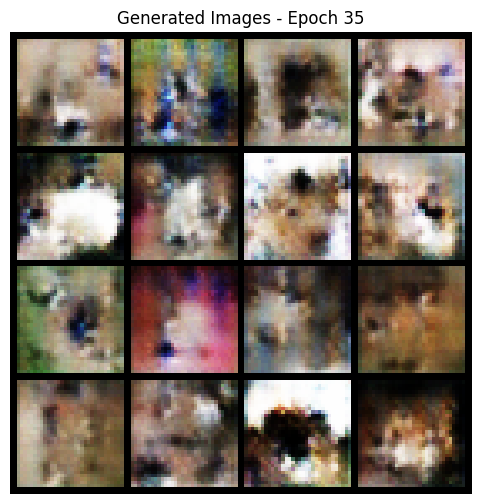

100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


Epoch 36/50 | G Loss: 466.36 | D Loss: 47.01


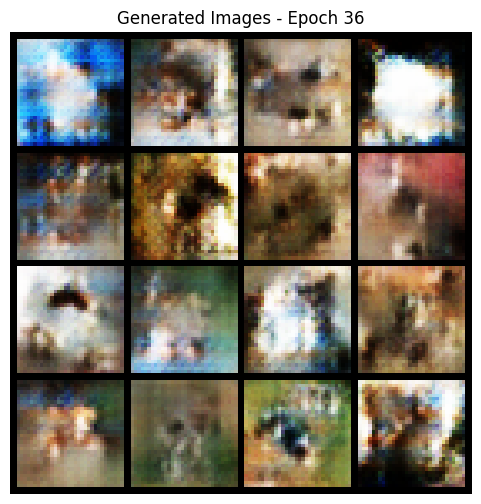

100%|██████████| 157/157 [00:05<00:00, 26.75it/s]


Epoch 37/50 | G Loss: 452.56 | D Loss: 45.47


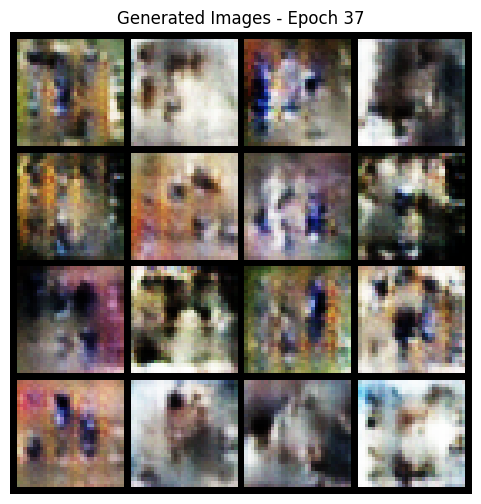

100%|██████████| 157/157 [00:06<00:00, 24.16it/s]


Epoch 38/50 | G Loss: 438.20 | D Loss: 44.59


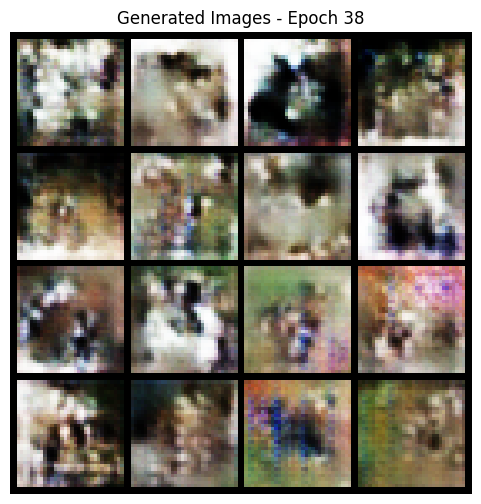

100%|██████████| 157/157 [00:05<00:00, 26.56it/s]


Epoch 39/50 | G Loss: 440.41 | D Loss: 44.35


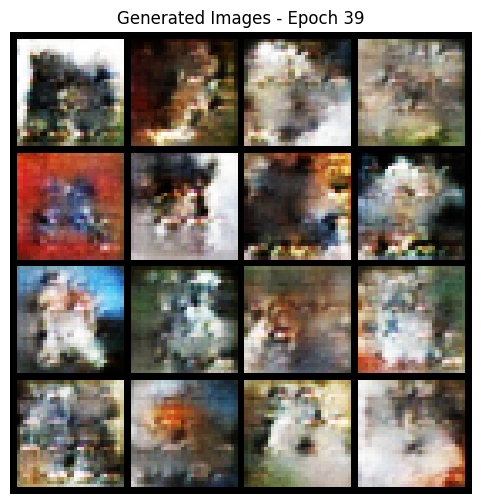

100%|██████████| 157/157 [00:06<00:00, 24.03it/s]

Epoch 40/50 | G Loss: 450.04 | D Loss: 42.42


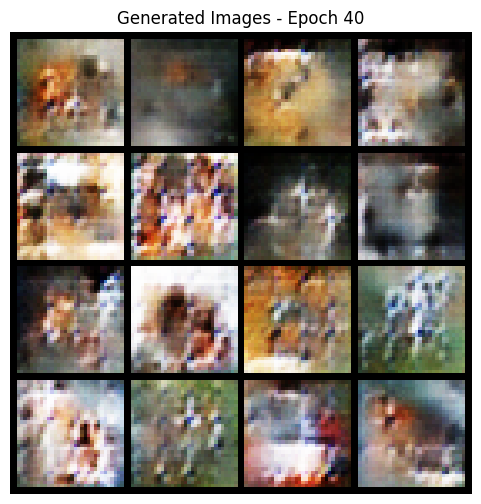

100%|██████████| 157/157 [00:05<00:00, 26.52it/s]


Epoch 41/50 | G Loss: 529.48 | D Loss: 43.97


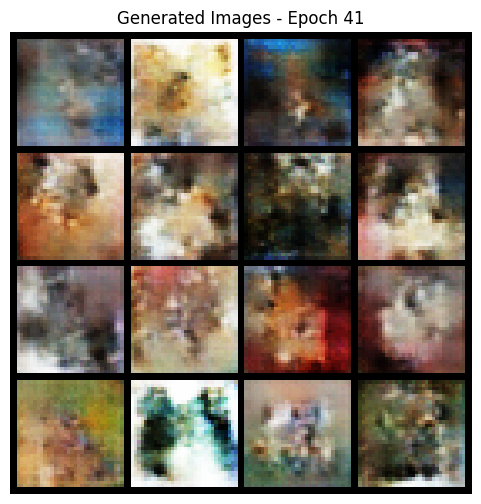

100%|██████████| 157/157 [00:06<00:00, 24.40it/s]


Epoch 42/50 | G Loss: 482.81 | D Loss: 47.87


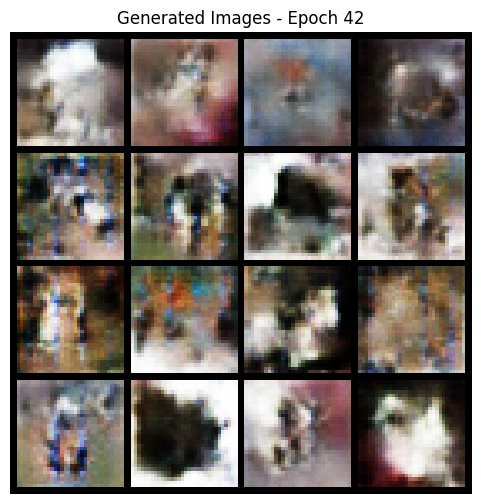

100%|██████████| 157/157 [00:05<00:00, 26.33it/s]


Epoch 43/50 | G Loss: 446.62 | D Loss: 44.19


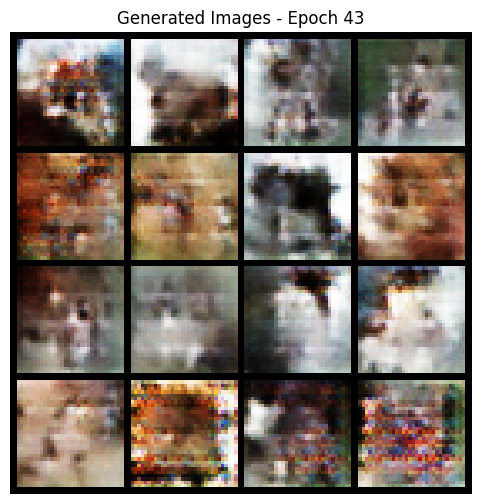

100%|██████████| 157/157 [00:06<00:00, 24.35it/s]


Epoch 44/50 | G Loss: 493.13 | D Loss: 45.66


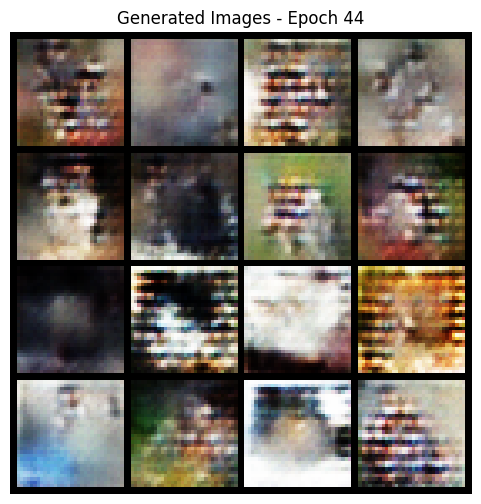

100%|██████████| 157/157 [00:05<00:00, 26.20it/s]


Epoch 45/50 | G Loss: 454.83 | D Loss: 46.38


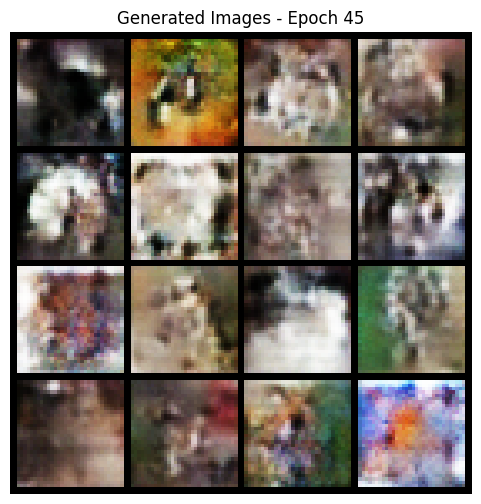

100%|██████████| 157/157 [00:06<00:00, 24.50it/s]


Epoch 46/50 | G Loss: 459.22 | D Loss: 45.78


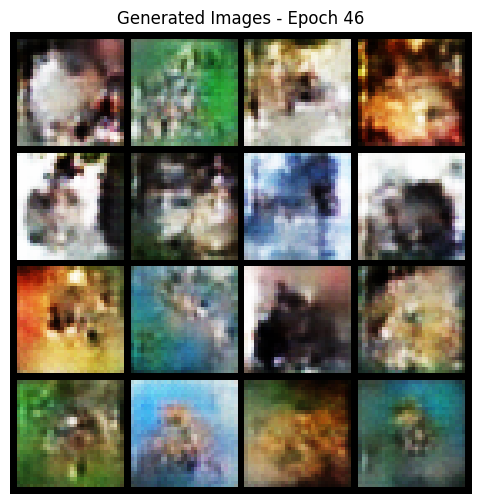

100%|██████████| 157/157 [00:06<00:00, 25.87it/s]


Epoch 47/50 | G Loss: 439.94 | D Loss: 44.30


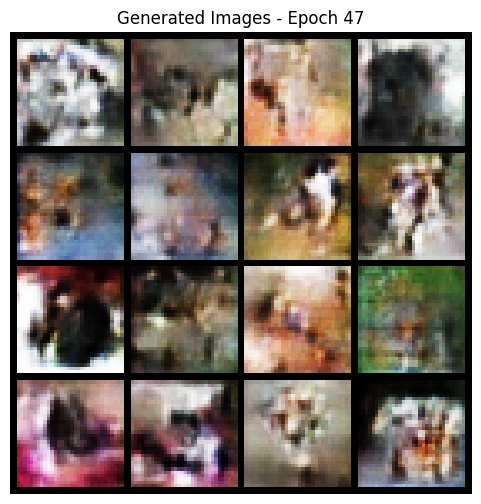

100%|██████████| 157/157 [00:06<00:00, 24.11it/s]


Epoch 48/50 | G Loss: 459.21 | D Loss: 43.27


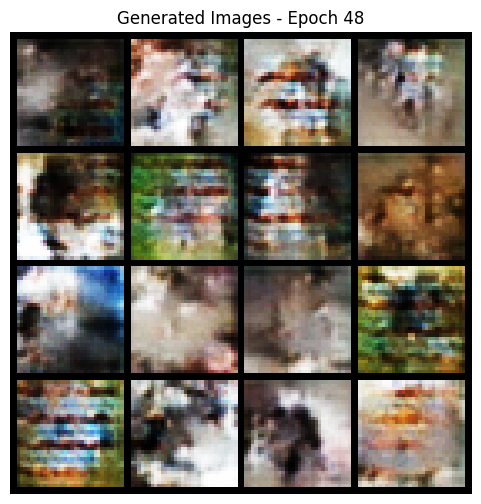

100%|██████████| 157/157 [00:06<00:00, 24.91it/s]

Epoch 49/50 | G Loss: 447.81 | D Loss: 48.39


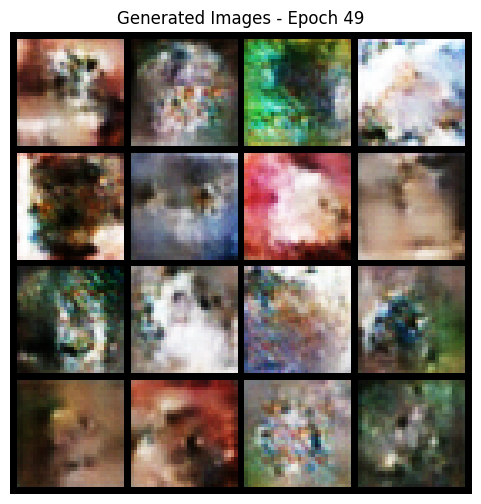

100%|██████████| 157/157 [00:06<00:00, 23.98it/s]


Epoch 50/50 | G Loss: 429.18 | D Loss: 45.32


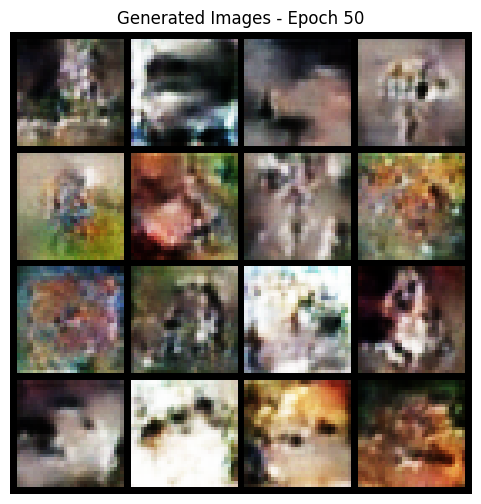

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================================
# ✅ Define Generator
# ======================================
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.BatchNorm1d(256 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()  # output in [-1, 1]
        )

    def forward(self, z):
        return self.net(z)

# ======================================
# ✅ Define Discriminator with Feature Output
# ======================================
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 32x32 → 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16 → 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, 4, 2, 1),  # 8x8 → 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, _=None):
        feats = self.features(x)
        out = self.classifier(feats)
        return out

    def get_features(self, x):
        return self.features(x)

# ======================================
# ✅ Setup CIFAR-10 (Cat/Dog Only)
# ======================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cat_dog_indices = [i for i, (_, label) in enumerate(trainset) if label in [3, 5]]  # 3 = cat, 5 = dog
trainloader_cd = DataLoader(Subset(trainset, cat_dog_indices), batch_size=64, shuffle=True)

# ======================================
# ✅ Training Setup
# ======================================
latent_dim = 100
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))
criterion = nn.BCELoss()

def smooth_labels(labels, smooth_factor=0.1):
    return labels * (1.0 - smooth_factor) + (smooth_factor / 2)

def feature_matching_loss(real_feats, fake_feats):
    return torch.mean((real_feats - fake_feats) ** 2)

# ======================================
# ✅ Training Loop
# ======================================
num_epochs = 50

for epoch in range(num_epochs):
    g_loss_total = 0
    d_loss_total = 0

    for real_imgs, _ in tqdm.tqdm(trainloader_cd):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ========== Train Discriminator ==========
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)

        real_labels = smooth_labels(torch.ones(batch_size, 1).to(device), 0.1)
        fake_labels = smooth_labels(torch.zeros(batch_size, 1).to(device), 0.1)

        real_score = D(real_imgs)
        fake_score = D(fake_imgs.detach())

        d_loss_real = criterion(real_score, real_labels)
        d_loss_fake = criterion(fake_score, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # ========== Train Generator ==========
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = G(z)
        g_score = D(gen_imgs)
        g_loss = criterion(g_score, real_labels)

        # Feature Matching
        real_feat = D.get_features(real_imgs)
        fake_feat = D.get_features(gen_imgs)
        fm_loss = feature_matching_loss(real_feat, fake_feat)

        g_total_loss = g_loss + 0.5 * fm_loss

        g_optimizer.zero_grad()
        g_total_loss.backward()
        g_optimizer.step()

        g_loss_total += g_total_loss.item()
        d_loss_total += d_loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | G Loss: {g_loss_total:.2f} | D Loss: {d_loss_total:.2f}")

    # Visualize generated samples
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        samples = G(z)
        grid = torchvision.utils.make_grid(samples, nrow=4, normalize=True)
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f"Generated Images - Epoch {epoch+1}")
        plt.axis('off')
        plt.show()


# VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # ===== Encoder =====
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 32 → 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16 → 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 8 → 4
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

        # ===== Decoder =====
        self.decoder_input = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4 → 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8 → 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 16 → 32
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_encoded = self.encoder(x)
        x_encoded = x_encoded.view(x_encoded.size(0), -1)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        z = self.reparameterize(mu, logvar)
        x_decoded = self.decoder_input(z).view(-1, 256, 4, 4)
        x_recon = self.decoder(x_decoded)
        return x_recon, mu, logvar




Vae LOSS

In [ ]:
vae = VAE(latent_dim=100).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0002)

def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


VAE Training

100%|██████████| 79/79 [00:04<00:00, 18.32it/s]


Epoch 1 | Loss: 6156644.05


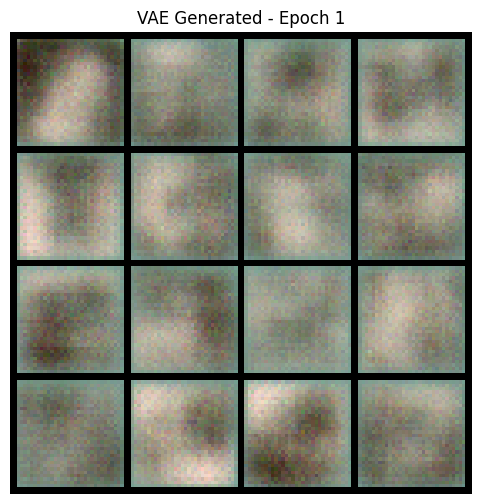

100%|██████████| 79/79 [00:03<00:00, 20.92it/s]


Epoch 2 | Loss: 3732747.85


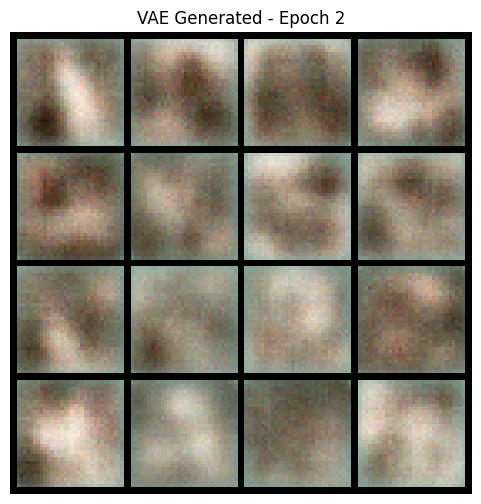

100%|██████████| 79/79 [00:04<00:00, 18.39it/s]

Epoch 3 | Loss: 3223219.87


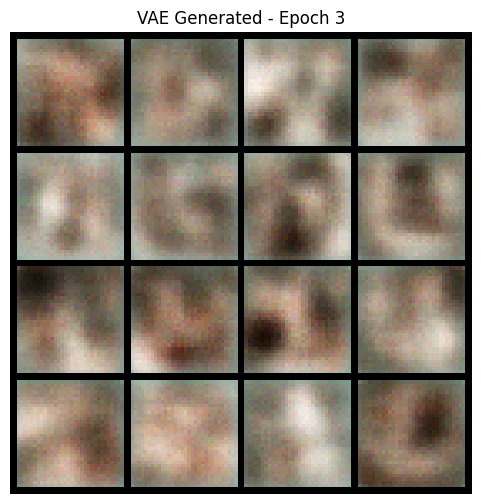

100%|██████████| 79/79 [00:03<00:00, 21.34it/s]

Epoch 4 | Loss: 2840069.56


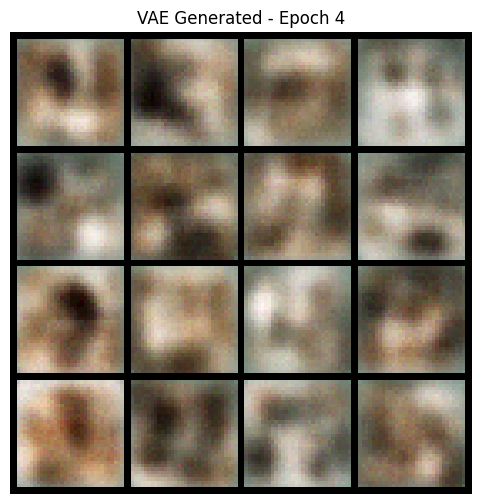

100%|██████████| 79/79 [00:03<00:00, 21.14it/s]

Epoch 5 | Loss: 2641770.03


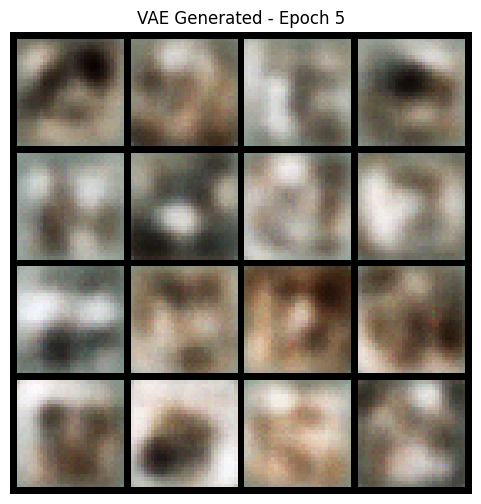

100%|██████████| 79/79 [00:04<00:00, 18.01it/s]

Epoch 6 | Loss: 2496459.60


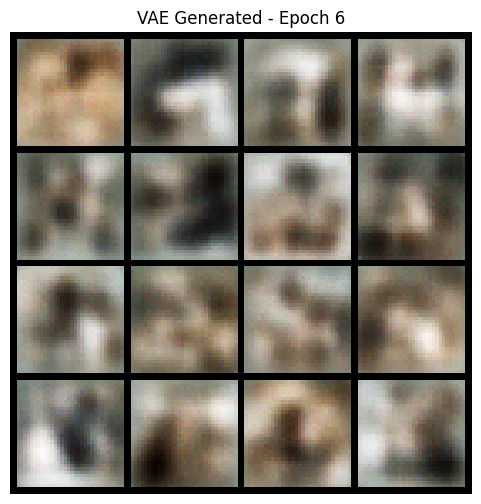

100%|██████████| 79/79 [00:03<00:00, 20.31it/s]

Epoch 7 | Loss: 2389324.86


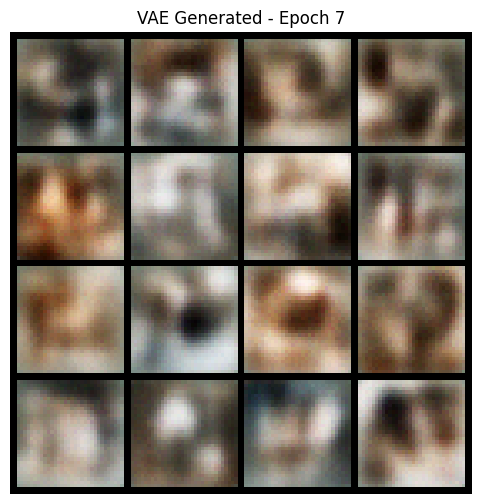

100%|██████████| 79/79 [00:03<00:00, 21.10it/s]

Epoch 8 | Loss: 2303049.57


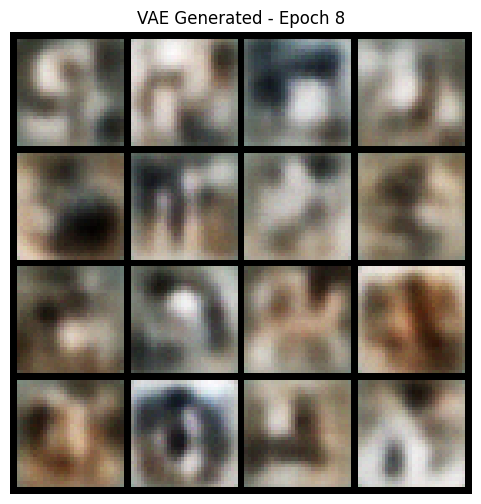

100%|██████████| 79/79 [00:04<00:00, 16.42it/s]


Epoch 9 | Loss: 2246640.06


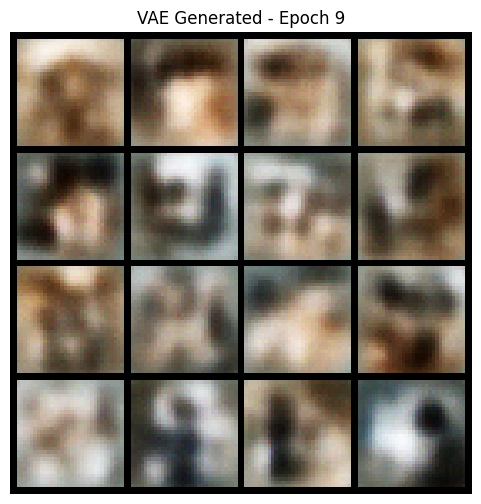

100%|██████████| 79/79 [00:04<00:00, 19.55it/s]

Epoch 10 | Loss: 2200268.08


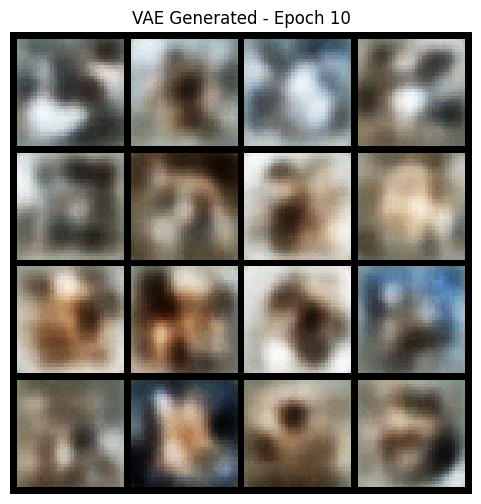

100%|██████████| 79/79 [00:03<00:00, 20.28it/s]

Epoch 11 | Loss: 2165555.50


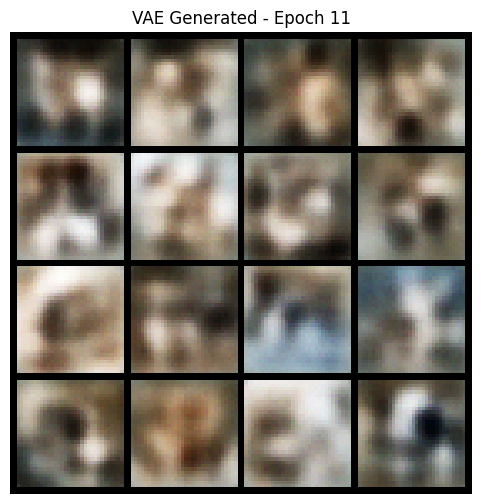

100%|██████████| 79/79 [00:04<00:00, 17.98it/s]

Epoch 12 | Loss: 2134905.23


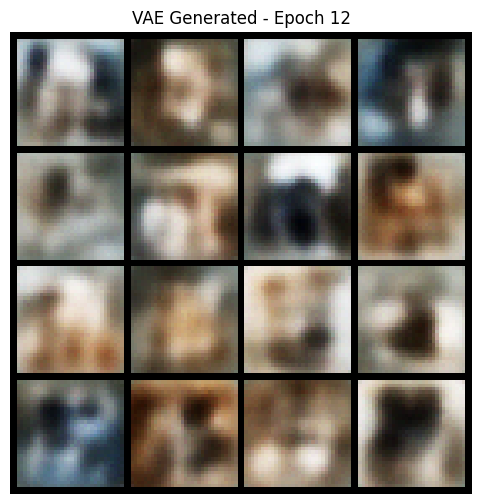

100%|██████████| 79/79 [00:03<00:00, 20.71it/s]

Epoch 13 | Loss: 2109262.37


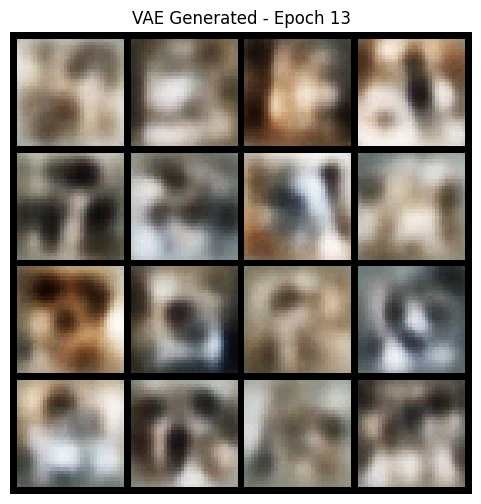

100%|██████████| 79/79 [00:03<00:00, 20.51it/s]

Epoch 14 | Loss: 2087923.43


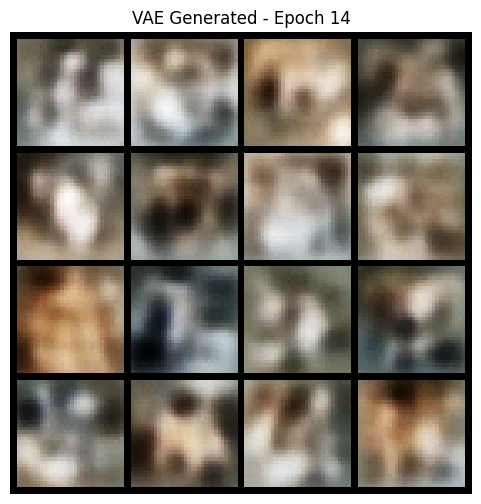

100%|██████████| 79/79 [00:04<00:00, 16.99it/s]


Epoch 15 | Loss: 2066950.64


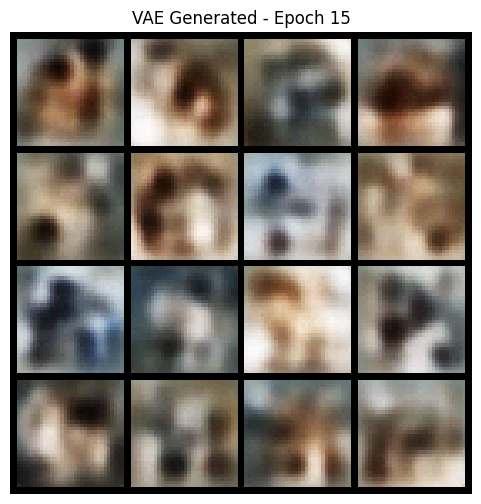

100%|██████████| 79/79 [00:04<00:00, 19.12it/s]

Epoch 16 | Loss: 2050003.05


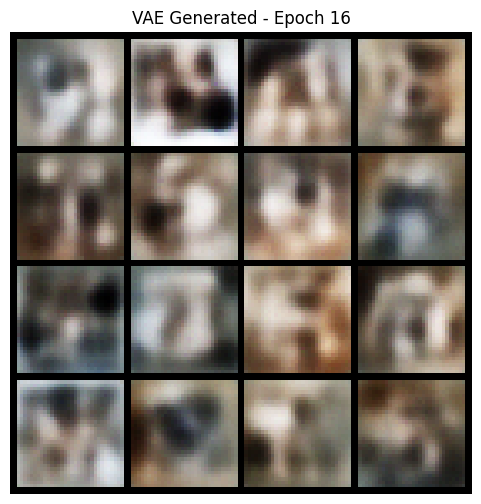

100%|██████████| 79/79 [00:04<00:00, 18.36it/s]


Epoch 17 | Loss: 2032730.25


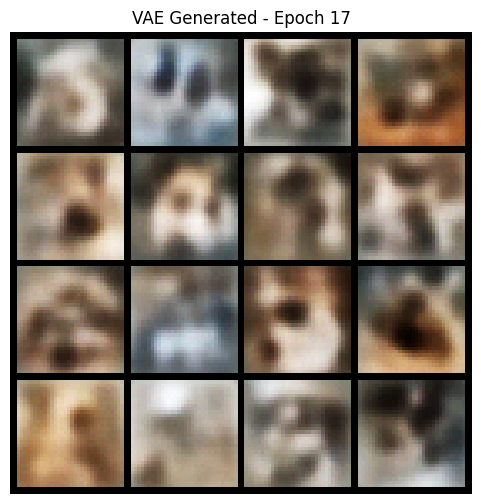

100%|██████████| 79/79 [00:04<00:00, 17.14it/s]

Epoch 18 | Loss: 2023595.66


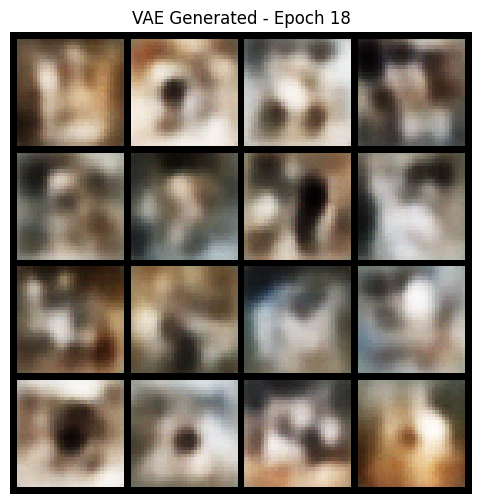

100%|██████████| 79/79 [00:04<00:00, 19.57it/s]


Epoch 19 | Loss: 2010332.93


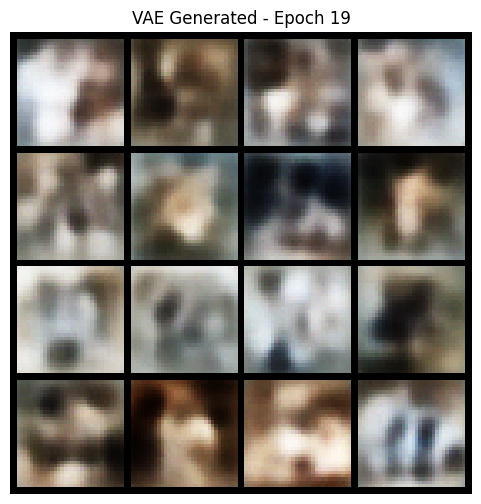

100%|██████████| 79/79 [00:04<00:00, 17.75it/s]


Epoch 20 | Loss: 2001613.88


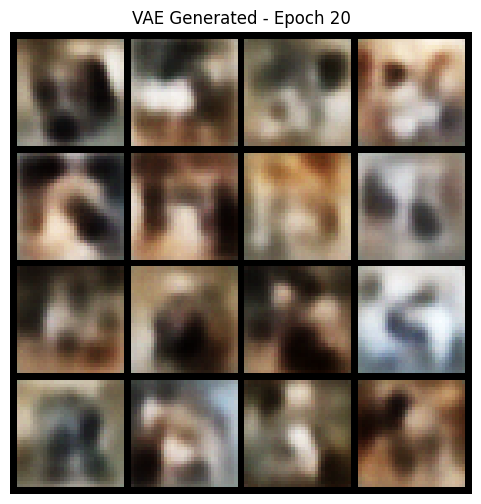

100%|██████████| 79/79 [00:04<00:00, 17.80it/s]


Epoch 21 | Loss: 1990908.98


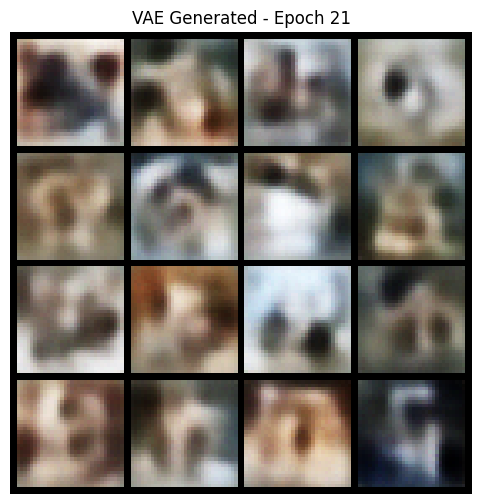

100%|██████████| 79/79 [00:04<00:00, 18.97it/s]

Epoch 22 | Loss: 1974117.49


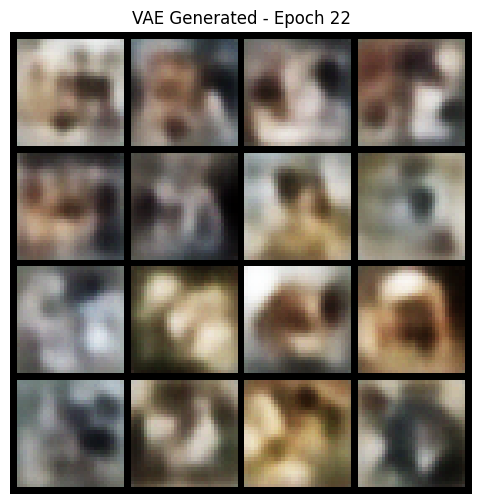

100%|██████████| 79/79 [00:04<00:00, 16.70it/s]

Epoch 23 | Loss: 1959883.18


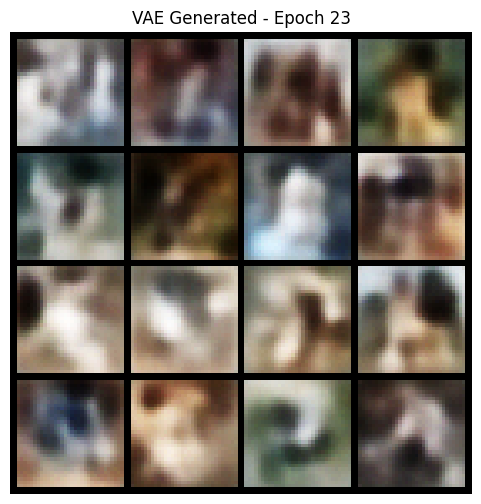

100%|██████████| 79/79 [00:04<00:00, 17.38it/s]

Epoch 24 | Loss: 1950632.00


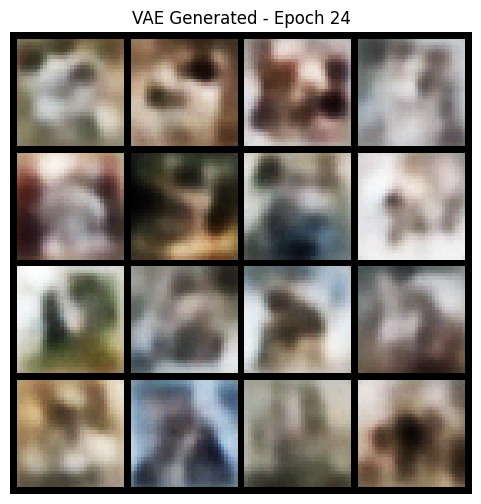

100%|██████████| 79/79 [00:04<00:00, 18.46it/s]


Epoch 25 | Loss: 1943168.71


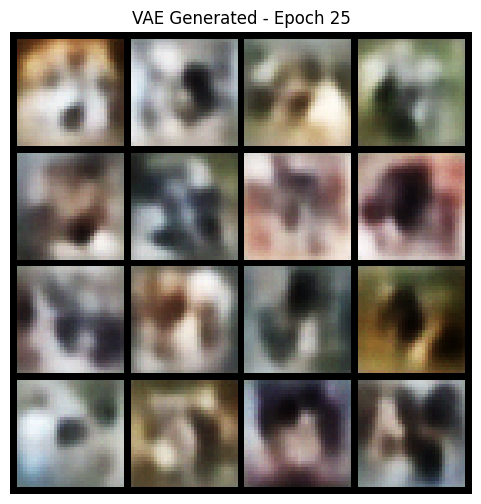

100%|██████████| 79/79 [00:05<00:00, 15.16it/s]


Epoch 26 | Loss: 1931248.10


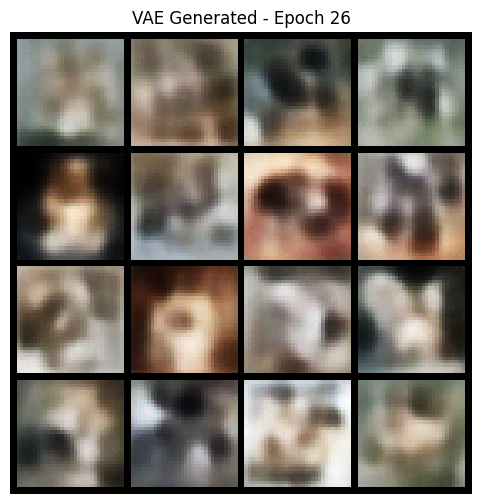

100%|██████████| 79/79 [00:04<00:00, 18.62it/s]

Epoch 27 | Loss: 1925228.90


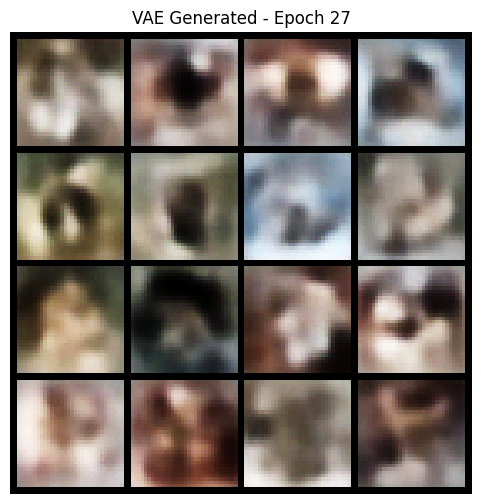

100%|██████████| 79/79 [00:04<00:00, 17.08it/s]


Epoch 28 | Loss: 1919645.20


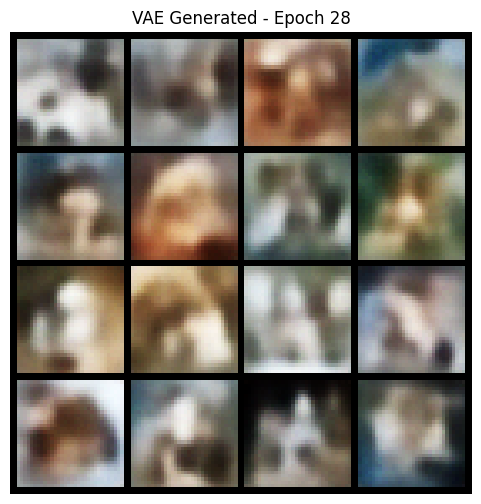

100%|██████████| 79/79 [00:04<00:00, 16.91it/s]


Epoch 29 | Loss: 1909930.48


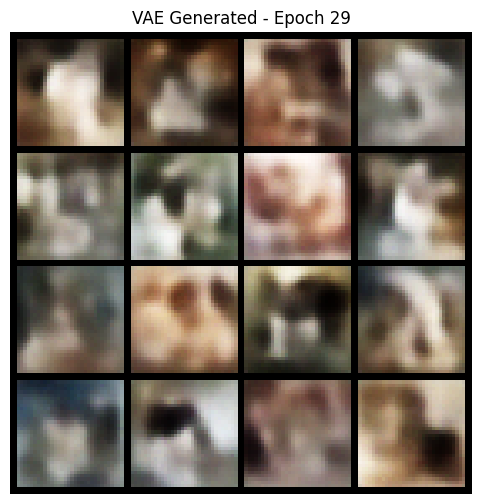

100%|██████████| 79/79 [00:04<00:00, 18.69it/s]

Epoch 30 | Loss: 1904518.15


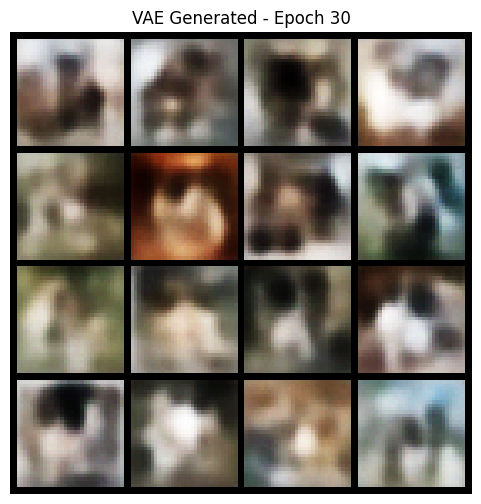

100%|██████████| 79/79 [00:04<00:00, 16.64it/s]


Epoch 31 | Loss: 1896941.03


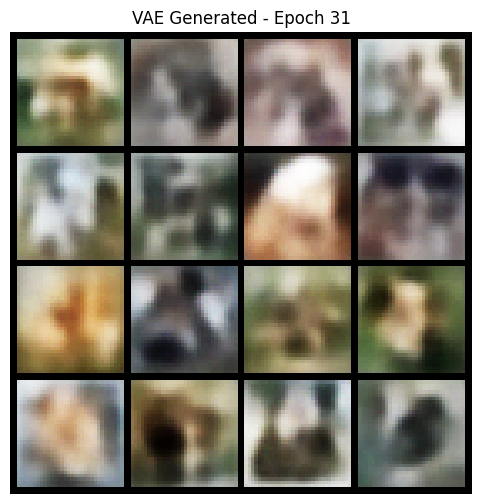

100%|██████████| 79/79 [00:04<00:00, 18.48it/s]


Epoch 32 | Loss: 1891699.79


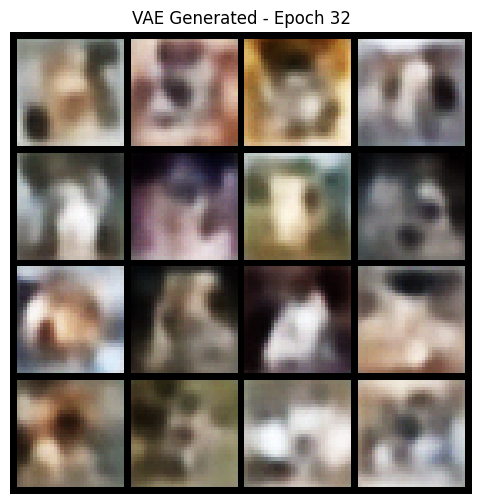

100%|██████████| 79/79 [00:04<00:00, 18.53it/s]


Epoch 33 | Loss: 1887242.49


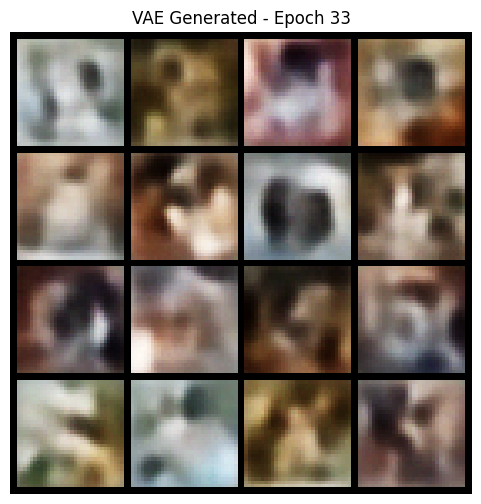

100%|██████████| 79/79 [00:04<00:00, 16.41it/s]


Epoch 34 | Loss: 1882770.32


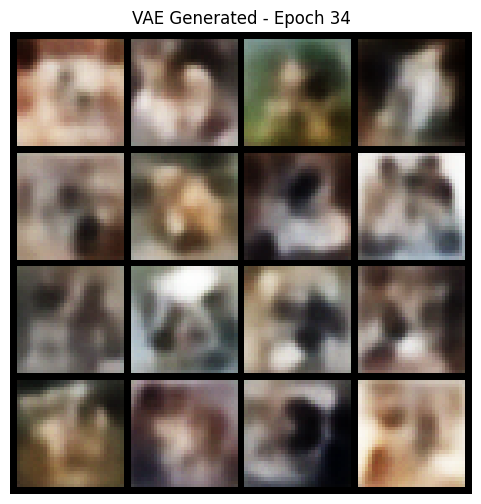

100%|██████████| 79/79 [00:04<00:00, 18.68it/s]


Epoch 35 | Loss: 1877443.78


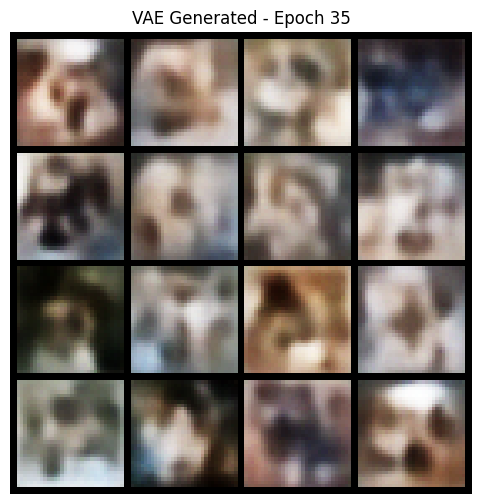

100%|██████████| 79/79 [00:04<00:00, 18.66it/s]


Epoch 36 | Loss: 1875763.32


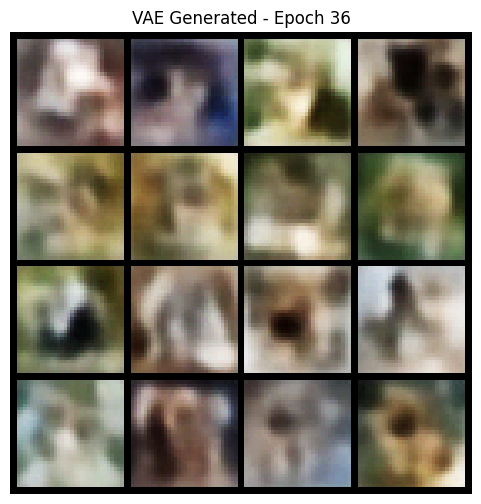

100%|██████████| 79/79 [00:04<00:00, 16.92it/s]


Epoch 37 | Loss: 1869504.24


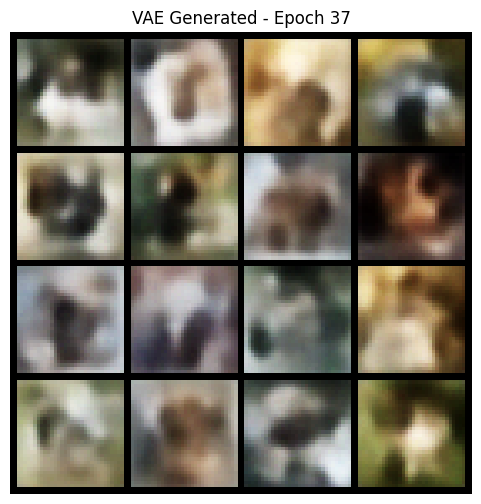

100%|██████████| 79/79 [00:04<00:00, 18.69it/s]


Epoch 38 | Loss: 1867329.09


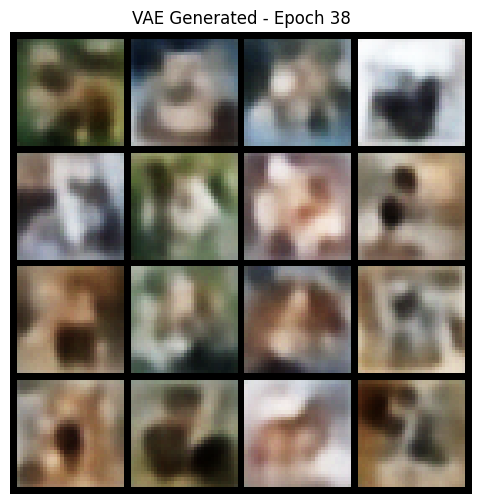

100%|██████████| 79/79 [00:04<00:00, 18.58it/s]


Epoch 39 | Loss: 1862816.09


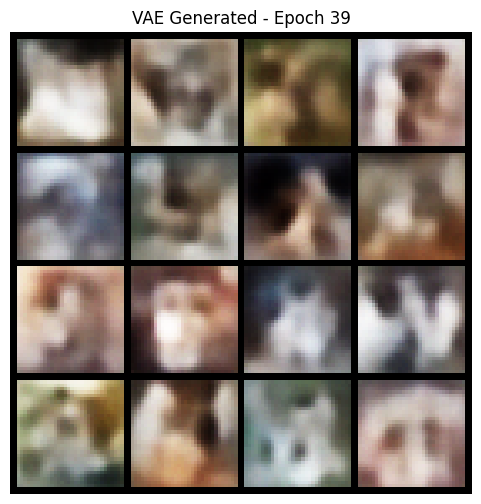

100%|██████████| 79/79 [00:04<00:00, 15.98it/s]


Epoch 40 | Loss: 1858926.65


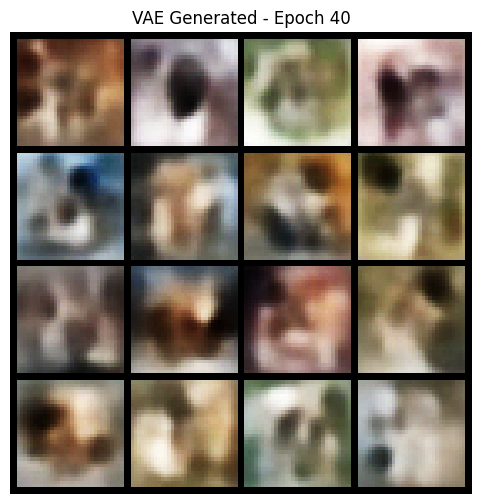

100%|██████████| 79/79 [00:04<00:00, 18.78it/s]


Epoch 41 | Loss: 1856195.28


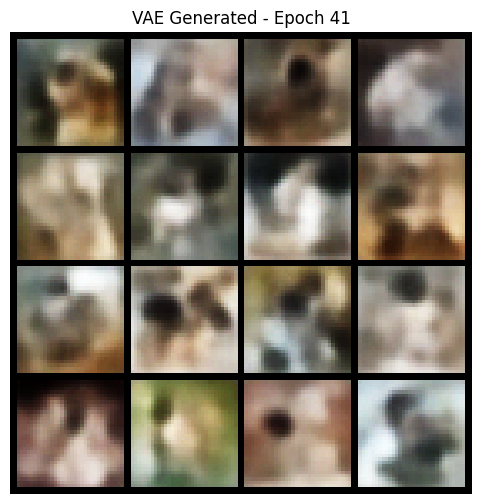

100%|██████████| 79/79 [00:04<00:00, 17.78it/s]


Epoch 42 | Loss: 1852828.36


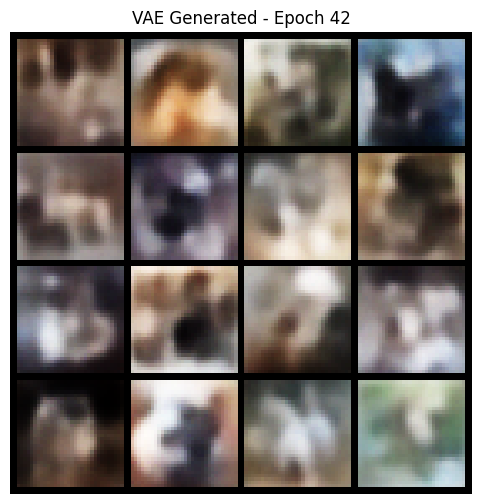

100%|██████████| 79/79 [00:04<00:00, 16.92it/s]


Epoch 43 | Loss: 1849377.03


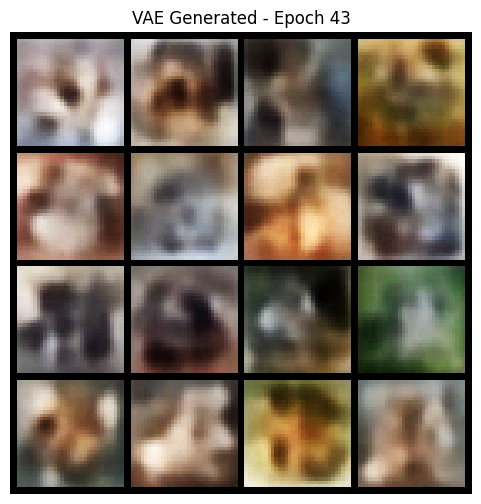

100%|██████████| 79/79 [00:04<00:00, 18.74it/s]


Epoch 44 | Loss: 1842864.30


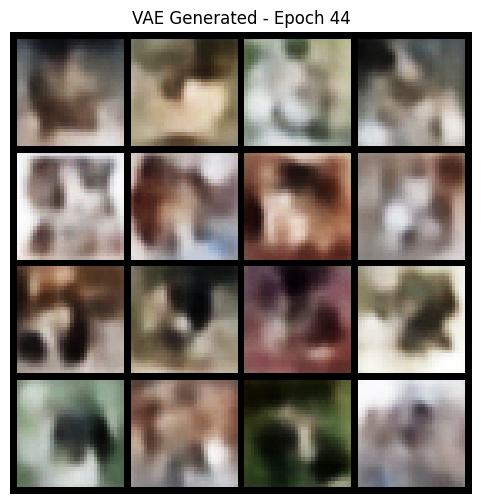

100%|██████████| 79/79 [00:04<00:00, 16.18it/s]


Epoch 45 | Loss: 1842368.83


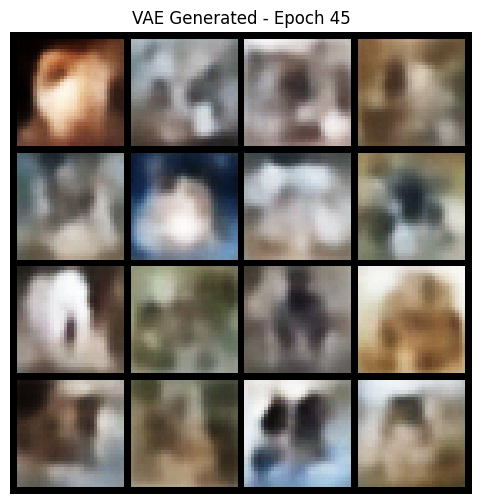

100%|██████████| 79/79 [00:04<00:00, 17.69it/s]


Epoch 46 | Loss: 1837885.27


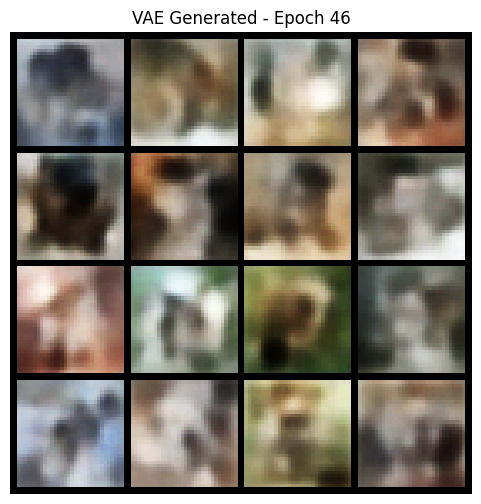

100%|██████████| 79/79 [00:04<00:00, 18.39it/s]


Epoch 47 | Loss: 1836660.23


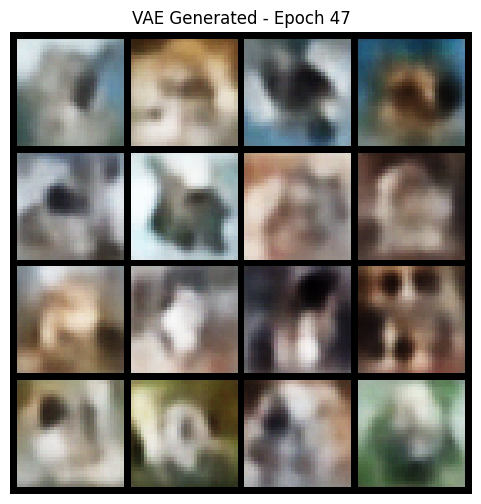

100%|██████████| 79/79 [00:04<00:00, 15.83it/s]


Epoch 48 | Loss: 1832703.09


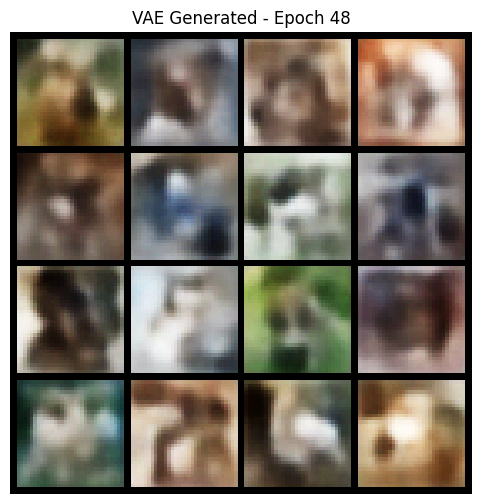

100%|██████████| 79/79 [00:04<00:00, 18.69it/s]


Epoch 49 | Loss: 1829885.76


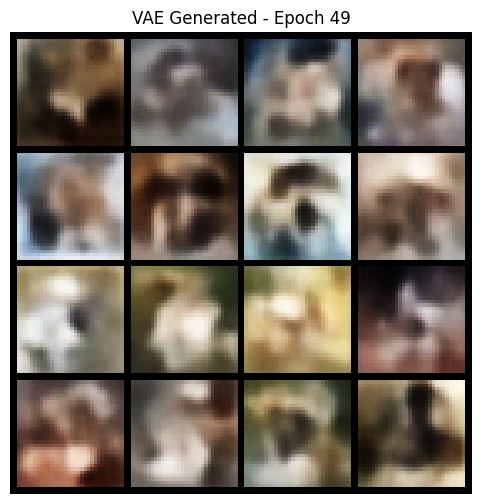

100%|██████████| 79/79 [00:04<00:00, 19.00it/s]


Epoch 50 | Loss: 1825862.53


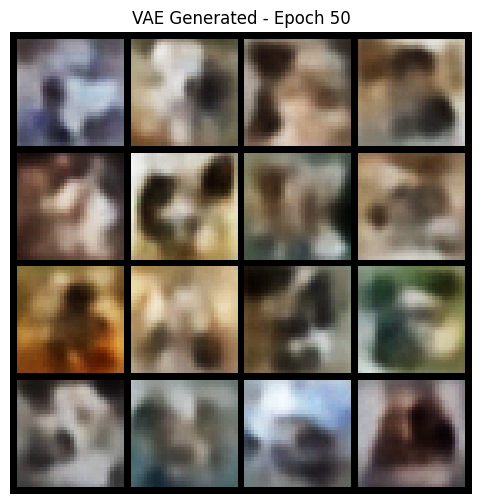

In [ ]:
import tqdm
from tqdm import tqdm

num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0
    for real_imgs, _ in tqdm(trainloader_cd):
        real_imgs = real_imgs.to(device)

        recon_imgs, mu, logvar = vae(real_imgs)
        loss = loss_function(recon_imgs, real_imgs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.2f}")

    # Show some generated images
    with torch.no_grad():
        z = torch.randn(16, vae.latent_dim).to(device)
        decoded = vae.decoder(vae.decoder_input(z).view(-1, 256, 4, 4))
        grid = torchvision.utils.make_grid(decoded, nrow=4, normalize=True)
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f"VAE Generated - Epoch {epoch+1}")
        plt.axis("off")
        plt.show()


In [ ]:
def compare_models(generator, vae):
    generator.eval()
    vae.eval()

    with torch.no_grad():
        z = torch.randn(16, 100).to(device)

        gan_imgs = generator(z)
        vae_imgs = vae.decoder(vae.decoder_input(z).view(-1, 256, 4, 4))

        def show(imgs, title):
            grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
            plt.figure(figsize=(6,6))
            plt.imshow(grid.permute(1, 2, 0).cpu())
            plt.title(title)
            plt.axis("off")
            plt.show()

        show(gan_imgs, "GAN Generated Images")
        show(vae_imgs, "VAE Generated Images")


The GAN model generates sharper images due to its adversarial training, where the generator learns to fool the discriminator, leading to more realistic outputs. However, GANs can suffer from instability and mode collapse.

On the other hand, the VAE model tends to produce blurrier images. This is because it optimizes a reconstruction loss combined with a KL divergence term, enforcing a smooth latent space but often at the cost of sharpness.

Feature matching in GAN helped stabilize training and improved image quality. VAE, while more stable, produces less realistic images compared to GAN for the same dataset (CIFAR-10 cat/dog subset).

Thus, for high-quality image generation, GANs are preferable. For latent space exploration and structure, VAEs are more interpretable and controllable.


# **Question - 2 Cycle GANS**

In [ ]:
import zipfile
import os
import shutil

# ✅ Unzip the uploaded test.zip
zip_path = "/content/test.zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ Create CycleGAN-compatible folders
os.makedirs("/content/data/trainA", exist_ok=True)  # photos → real faces
os.makedirs("/content/data/trainB", exist_ok=True)  # sketches

# ✅ Move files into trainA and trainB
photo_dir = os.path.join(extract_path, "photos")
sketch_dir = os.path.join(extract_path, "sketches")

for file in os.listdir(photo_dir):
    full_path = os.path.join(photo_dir, file)
    if os.path.isfile(full_path):
        shutil.move(full_path, "/content/data/trainA")

for file in os.listdir(sketch_dir):
    full_path = os.path.join(sketch_dir, file)
    if os.path.isfile(full_path):
        shutil.move(full_path, "/content/data/trainB")

print("✅ Dataset is ready at /content/data/trainA (faces) and trainB (sketches)")


✅ Dataset is ready at /content/data/trainA (faces) and trainB (sketches)


In [ ]:
import zipfile
import os

# Unzip dataset
with zipfile.ZipFile("test.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

# Check extracted folders
os.listdir("dataset")


['photos', 'sketches']

In [ ]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import glob
import random

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class SketchPhotoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.photos = sorted(glob.glob(os.path.join(root_dir, "photos", "*.*")))
        self.sketches = sorted(glob.glob(os.path.join(root_dir, "sketches", "*.*")))
        self.transform = transform

    def __len__(self):
        return max(len(self.photos), len(self.sketches))

    def __getitem__(self, index):
        photo_path = self.photos[index % len(self.photos)]
        sketch_path = self.sketches[random.randint(0, len(self.sketches) - 1)]

        photo = Image.open(photo_path).convert("RGB")
        sketch = Image.open(sketch_path).convert("RGB")

        if self.transform:
            photo = self.transform(photo)
            sketch = self.transform(sketch)

        return {"photo": photo, "sketch": sketch}


In [ ]:
from torch.utils.data import DataLoader

dataset = SketchPhotoDataset("dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import zipfile, os, shutil

# Unzip test.zip
with zipfile.ZipFile("test.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

# Create required structure for ImageFolder
os.makedirs("dataset/sketches/dummy", exist_ok=True)
os.makedirs("dataset/photos/dummy", exist_ok=True)

# Move all images into dummy class folders
for file in os.listdir("dataset/sketches"):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        shutil.move(f"dataset/sketches/{file}", "dataset/sketches/dummy/")

for file in os.listdir("dataset/photos"):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        shutil.move(f"dataset/photos/{file}", "dataset/photos/dummy/")


In [ ]:
import torch
import torch.nn as nn

# Generator: ResNet style
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=6):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 3, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True)
        ]

        for _ in range(n_blocks):
            model += [ResnetBlock(256)]

        model += [
            nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# PatchGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super().__init__()
        model = [
            nn.Conv2d(input_nc, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, 4, 1, 1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 1, 4, 1, 1)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
!nvidia-smi


Device: cuda
Wed Apr 16 14:54:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             32W /   70W |    5486MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [ ]:
import os
import torch
import torch.nn as nn
import itertools
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

# ==============================
# ✅ Config
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1
img_size = 128
lambda_cycle = 10.0
lambda_identity = 5.0
num_epochs = 10

# ==============================
# ✅ Prepare Dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_X = ImageFolder("dataset/sketches", transform=transform)
dataset_Y = ImageFolder("dataset/photos", transform=transform)

loader_X = DataLoader(dataset_X, batch_size=1, shuffle=True)
loader_Y = DataLoader(dataset_Y, batch_size=1, shuffle=True)

# ==============================
# ✅ Initialize Models
# ==============================
G_XtoY = Generator(3, 3).to(device)
G_YtoX = Generator(3, 3).to(device)
D_X = Discriminator(3).to(device)
D_Y = Discriminator(3).to(device)

# ==============================
# ✅ Losses and Optimizers
# ==============================
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

optimizer_G = torch.optim.Adam(itertools.chain(G_XtoY.parameters(), G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

lr_scheduler_G = lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 50) / 50)
lr_scheduler_D_X = lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 50) / 50)
lr_scheduler_D_Y = lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 50) / 50)

real_label = torch.ones((batch_size, 1, 30, 30), device=device)
fake_label = torch.zeros((batch_size, 1, 30, 30), device=device)

# ==============================
# ✅ Training Loop
# ==============================
for epoch in range(num_epochs):
    for (x_real, _), (y_real, _) in zip(loader_X, loader_Y):
        x_real, y_real = x_real.to(device), y_real.to(device)

        # --- Train Generators ---
        optimizer_G.zero_grad()

        y_fake = G_XtoY(x_real)
        x_fake = G_YtoX(y_real)

        d_y_fake = D_Y(y_fake)
        d_x_fake = D_X(x_fake)

        loss_GAN_XY = criterion_GAN(d_y_fake, real_label)
        loss_GAN_YX = criterion_GAN(d_x_fake, real_label)

        x_recon = G_YtoX(y_fake)
        y_recon = G_XtoY(x_fake)
        loss_cycle_X = criterion_cycle(x_recon, x_real)
        loss_cycle_Y = criterion_cycle(y_recon, y_real)

        x_id = G_YtoX(x_real)
        y_id = G_XtoY(y_real)
        loss_id_X = criterion_identity(x_id, x_real)
        loss_id_Y = criterion_identity(y_id, y_real)

        loss_G = loss_GAN_XY + loss_GAN_YX + lambda_cycle * (loss_cycle_X + loss_cycle_Y) + lambda_identity * (loss_id_X + loss_id_Y)
        loss_G.backward()
        optimizer_G.step()

        # --- Train Discriminator X ---
        optimizer_D_X.zero_grad()
        loss_D_X_real = criterion_GAN(D_X(x_real), real_label)
        loss_D_X_fake = criterion_GAN(D_X(x_fake.detach()), fake_label)
        loss_D_X = (loss_D_X_real + loss_D_X_fake) * 0.5
        loss_D_X.backward()
        optimizer_D_X.step()

        # --- Train Discriminator Y ---
        optimizer_D_Y.zero_grad()
        loss_D_Y_real = criterion_GAN(D_Y(y_real), real_label)
        loss_D_Y_fake = criterion_GAN(D_Y(y_fake.detach()), fake_label)
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) * 0.5
        loss_D_Y.backward()
        optimizer_D_Y.step()

    print(f"[Epoch {epoch+1}/{num_epochs}] G: {loss_G.item():.4f} | D_X: {loss_D_X.item():.4f} | D_Y: {loss_D_Y.item():.4f}")

    os.makedirs("checkpoints", exist_ok=True)
    torch.save(G_XtoY.state_dict(), f"checkpoints/G_XtoY_{epoch+1}.pth")
    torch.save(G_YtoX.state_dict(), f"checkpoints/G_YtoX_{epoch+1}.pth")
    torch.save(D_X.state_dict(), f"checkpoints/D_X_{epoch+1}.pth")
    torch.save(D_Y.state_dict(), f"checkpoints/D_Y_{epoch+1}.pth")

    # Save image samples
    with torch.no_grad():
        fake_Y = G_XtoY(x_real)
        fake_X = G_YtoX(y_real)
        save_image((fake_Y + 1) / 2, f"checkpoints/fake_Y_{epoch+1}.png")
        save_image((fake_X + 1) / 2, f"checkpoints/fake_X_{epoch+1}.png")

    # Step schedulers
    lr_scheduler_G.step()
    lr_scheduler_D_X.step()
    lr_scheduler_D_Y.step()


[Epoch 1/10] G: 5.2745 | D_X: 0.1571 | D_Y: 0.2004
[Epoch 2/10] G: 4.6707 | D_X: 0.1122 | D_Y: 0.2157
[Epoch 3/10] G: 5.0343 | D_X: 0.1788 | D_Y: 0.1463
[Epoch 4/10] G: 3.6542 | D_X: 0.2580 | D_Y: 0.3492
[Epoch 5/10] G: 3.0119 | D_X: 0.1354 | D_Y: 0.1610
[Epoch 6/10] G: 5.1786 | D_X: 0.0649 | D_Y: 0.1040
[Epoch 7/10] G: 3.8251 | D_X: 0.1320 | D_Y: 0.1649
[Epoch 8/10] G: 5.9054 | D_X: 0.1239 | D_Y: 0.1108
[Epoch 9/10] G: 5.0669 | D_X: 0.1868 | D_Y: 0.0952
[Epoch 10/10] G: 4.2184 | D_X: 0.1526 | D_Y: 0.2894


In [33]:
!pip install Flask torch torchvision pillow ngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

FileNotFoundError: [Errno 2] No such file or directory: 'cycle_gan_model/generator.pth'